In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dir_path = "/content/drive/MyDrive/cropss"

In [3]:
from datetime import datetime
from tensorflow import keras 
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, Flatten, MaxPooling2D
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.resnet import preprocess_input
from PIL import Image
from torchvision import transforms

In [4]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.9 MB/s 


In [5]:
import efficientnet.keras as efn

In [6]:
img_class_mode_ = 'categorical'
rotation_range_ = 10       # 15 degrees rotation range for image augmentation
width_shift_range_ = 0.1  # 15% horizontal shift range for image augmentation
height_shift_range_ = 0.1 # 15% pixels veritcal shift range for image augmentation
zoom_range_ = 0.3          # zoom range 0.7 - 1.3 for image augmentation
brightness_range_ = (0.3, 0.8)   # brightness range slight darkening or slight brightening (50% is no change) for image augmentation
horizontal_flip_ = True    # horizontal flip on for image augmentation
interpolation_mode_ = "lanczos"  # higher quality interpolation for re-scaling (when applicable)
fill_mode_ = "reflect"  # reflect margin for shifted regions for image augmentation
keep_aspect_ratio_ = True

In [7]:
img_batch_size_ = 16
epochs_ = 150
checkpoint_path = "model_checkpoint_" + datetime.now().strftime('%Y%m%d-%H%M%S') + ".h5"
opt = keras.optimizers.Adam(learning_rate=0.0001)
optt = keras.optimizers.Adam(learning_rate=0.00001)

In [8]:
# load data and split into training and test/validation data sets
images_data = ImageDataGenerator(
    preprocessing_function = preprocess_input,  # Ref. https://keras.io/api/applications/vgg/#vgg19-function
    validation_split = 0.2,
    rotation_range = rotation_range_, width_shift_range = width_shift_range_,
    height_shift_range = height_shift_range_, zoom_range = zoom_range_,
    horizontal_flip = horizontal_flip_, fill_mode = fill_mode_, 
    brightness_range = brightness_range_)
trainD_shuffle = images_data.flow_from_directory(
    dir_path, shuffle = True, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
trainD_noshuffle = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,    
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
testD_noshuffle = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'validation')

Found 674 images belonging to 30 classes.
Found 674 images belonging to 30 classes.
Found 155 images belonging to 30 classes.


In [9]:
train_img_class_count = len(trainD_noshuffle.class_indices)
test_img_class_count = len(testD_noshuffle.class_indices)
if (train_img_class_count != test_img_class_count):
    raise Exception("Training and Testing Data Sets Not Aligned.")
img_class_count = test_img_class_count
print("image class count", img_class_count)

image class count 30


In [10]:
# get pre-trained CNN
cnn = efn.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
cnn.trainable = False

16804768/16804768 [==============================] - 1s 0us/step


In [11]:
# build nerual network 
model = Sequential([
    cnn,
    Flatten(),
    Dense(360, activation = 'relu'), 
    # Dropout(0.4),
    Dense(180, activation = 'relu'), 
    Dropout(0.25),
    Dense(90, activation = 'relu'), 
    Dropout(0.2),     
    Dense(img_class_count, activation = 'softmax')
])
model.compile(loss = CategoricalCrossentropy(), 
    optimizer=opt, 
     metrics = ['accuracy'])

In [12]:
# set up logging 
# and train nerual net

%load_ext tensorboard

log_dir = 'logs/batch/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/train'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, monitor="val_accuracy", batch_size = img_batch_size_,
    verbose=1, mode="max", save_weights_only=True, save_best_only=True)
history = model.fit(trainD_shuffle, epochs = epochs_, validation_data = testD_noshuffle, 
    callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/150
40/43 [==========================>...] - ETA: 15s - loss: 3.1895 - accuracy: 0.1278

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


43/43 [==============================] - ETA: 0s - loss: 3.1814 - accuracy: 0.1320
Epoch 1: val_accuracy improved from -inf to 0.29032, saving model to model_checkpoint_20221206-223331.h5
43/43 [==============================] - 291s 7s/step - loss: 3.1814 - accuracy: 0.1320 - val_loss: 2.6939 - val_accuracy: 0.2903
Epoch 2/150
43/43 [==============================] - ETA: 0s - loss: 2.4166 - accuracy: 0.3472
Epoch 2: val_accuracy improved from 0.29032 to 0.42581, saving model to model_checkpoint_20221206-223331.h5
43/43 [==============================] - 23s 536ms/step - loss: 2.4166 - accuracy: 0.3472 - val_loss: 2.2037 - val_accuracy: 0.4258
Epoch 3/150
43/43 [==============================] - ETA: 0s - loss: 1.8890 - accuracy: 0.4555
Epoch 3: val_accuracy improved from 0.42581 to 0.49032, saving model to model_checkpoint_20221206-223331.h5
43/43 [==============================] - 24s 558ms/step - loss: 1.8890 - accuracy: 0.4555 - val_loss: 2.0082 - val_accuracy: 0.4903
Epoch 4/150


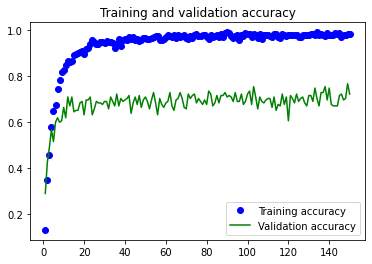

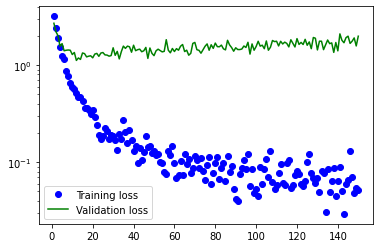

In [13]:
# CHANGE:  Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "g", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "g", label = "Validation loss")
plt.yscale("log")
plt.legend()
plt.show()

In [14]:
# restore checkpoint model
#model = keras.models.load_model(checkpoint_path)
model.load_weights(checkpoint_path)

In [15]:
# run prediction based on training data
train_scores = model.predict(trainD_noshuffle)
train_pred_labels = train_scores.argmax(axis = 1)

43/43 [==============================] - 19s 420ms/step


In [16]:
# evaluate trained network
print('')
print('')
print('Model Evaluation Using Training Data:')

print("Accuracy Score")
print(accuracy_score(trainD_noshuffle.labels, train_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(trainD_noshuffle.labels, train_pred_labels))



Model Evaluation Using Training Data:
Accuracy Score
0.9985163204747775
Confusion Matrix
[[26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 23  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  

In [17]:
# run prediction based on test data
test_scores = model.predict(testD_noshuffle)
test_pred_labels = test_scores.argmax(axis = 1)

10/10 [==============================] - 6s 508ms/step


In [18]:
# print confusion matrix 
print('')
print('')
print('Model Evaluation Using Test Data:')


print("Accuracy Score")
print(accuracy_score(testD_noshuffle.labels, test_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(testD_noshuffle.labels, test_pred_labels))



Model Evaluation Using Test Data:
Accuracy Score
0.7161290322580646
Confusion Matrix
[[3 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 6

In [19]:
cnn.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 360)               22579560  
                                                                 
 dense_1 (Dense)             (None, 180)               64980     
                                                                 
 dropout (Dropout)           (None, 180)               0         
                                                                 
 dense_2 (Dense)             (None, 90)                16290     
                                                        

In [20]:
model.compile(loss = CategoricalCrossentropy(), 
    optimizer=optt, 
     metrics = ['accuracy'])

In [21]:
%load_ext tensorboard

log_dir = 'logs/batch/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/train'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, monitor="val_accuracy", batch_size = img_batch_size_,
    verbose=1, mode="max", save_weights_only=True, save_best_only=True)
history = model.fit(trainD_shuffle, epochs = epochs_, validation_data = testD_noshuffle, 
    callbacks=[tensorboard_callback, checkpoint_callback])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/150


/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


43/43 [==============================] - ETA: 0s - loss: 4.3321 - accuracy: 0.4733
Epoch 1: val_accuracy improved from -inf to 0.69677, saving model to model_checkpoint_20221206-223331.h5
43/43 [==============================] - 37s 620ms/step - loss: 4.3321 - accuracy: 0.4733 - val_loss: 2.1525 - val_accuracy: 0.6968
Epoch 2/150
43/43 [==============================] - ETA: 0s - loss: 3.1763 - accuracy: 0.5593
Epoch 2: val_accuracy did not improve from 0.69677
43/43 [==============================] - 26s 605ms/step - loss: 3.1763 - accuracy: 0.5593 - val_loss: 1.9296 - val_accuracy: 0.6323
Epoch 3/150
43/43 [==============================] - ETA: 0s - loss: 2.5324 - accuracy: 0.6142
Epoch 3: val_accuracy did not improve from 0.69677
43/43 [==============================] - 24s 562ms/step - loss: 2.5324 - accuracy: 0.6142 - val_loss: 2.2459 - val_accuracy: 0.5806
Epoch 4/150
43/43 [==============================] - ETA: 0s - loss: 2.2639 - accuracy: 0.6231
Epoch 4: val_accuracy did not

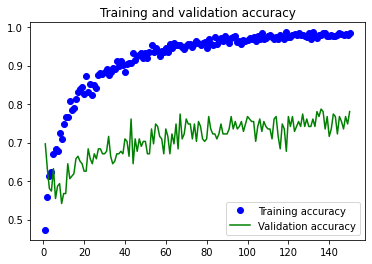

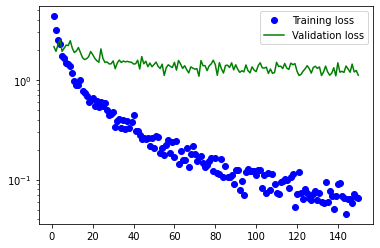

In [22]:
# CHANGE:  Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "g", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "g", label = "Validation loss")
plt.yscale("log")
plt.legend()
plt.show()

In [23]:
# restore checkpoint model
#model = keras.models.load_model(checkpoint_path)
model.load_weights(checkpoint_path)

In [24]:
# run prediction based on training data
train_scores = model.predict(trainD_noshuffle)
train_pred_labels = train_scores.argmax(axis = 1)

43/43 [==============================] - 19s 416ms/step


In [25]:
# evaluate trained network
print('')
print('')
print('Model Evaluation Using Training Data:')

print("Accuracy Score")
print(accuracy_score(trainD_noshuffle.labels, train_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(trainD_noshuffle.labels, train_pred_labels))



Model Evaluation Using Training Data:
Accuracy Score
0.9985163204747775
Confusion Matrix
[[26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  

In [26]:
# run prediction based on test data
test_scores = model.predict(testD_noshuffle)
test_pred_labels = test_scores.argmax(axis = 1)

10/10 [==============================] - 6s 581ms/step


In [27]:
# print confusion matrix 
print('')
print('')
print('Model Evaluation Using Test Data:')


print("Accuracy Score")
print(accuracy_score(testD_noshuffle.labels, test_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(testD_noshuffle.labels, test_pred_labels))



Model Evaluation Using Test Data:
Accuracy Score
0.7354838709677419
Confusion Matrix
[[3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 2 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 6